# Hate and Offense Detection With Undectable Class

In [1]:
# pip install nlpaug

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data=pd.read_csv("src/twitter_nepali.csv",encoding= 'unicode_escape')

In [4]:
data.info

<bound method DataFrame.info of        Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0               0      3            0                   0        3      2   
1               1      3            0                   3        0      1   
2               2      3            0                   3        0      1   
3               3      3            0                   2        1      1   
4               4      6            0                   6        0      1   
...           ...    ...          ...                 ...      ...    ...   
24817       25327      3            0                   0        3      3   
24818       25328      3            0                   0        3      3   
24819       25329      3            0                   0        3      3   
24820       25330      3            0                   0        3      3   
24821       25331      3            0                   0        3      3   

                                           

In [5]:
data.head(15)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


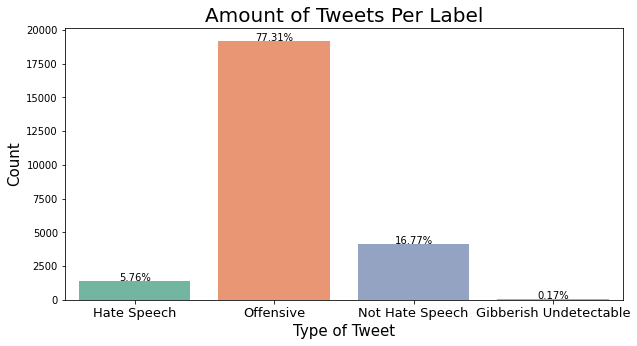

In [6]:
plt.figure(figsize = (10,5))
ax = sns.countplot(data['class'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Hate Speech','Offensive', 'Not Hate Speech','Gibberish Undetectable'],fontsize = 13)

total = float(len(data)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

plt.savefig(r'C:\Users\acer\Desktop\Projet\visualizations\class_imbalance_neplai.png', bbox_inches = "tight", pad_inches=.5)

In [7]:
data=data[['tweet','class']]
data.head

<bound method NDFrame.head of                                                    tweet  class
0      !!! RT @mayasolovely: As a woman you shouldn't...      2
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1
...                                                  ...    ...
24817                           !!!!aaba ta aati bho hai      3
24818                  !!!!!aada mental pagal bahi sakyo      3
24819      !!!!!aaba pura mental huna baki cha ani skayo      3
24820                          !!!!!bho hauu bho ati bho      3
24821  !!! a yaar double meaning word detect garnu parna      3

[24822 rows x 2 columns]>

In [8]:
data['tweet'].loc[1]

'!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!'

In [9]:
tweet=data.tweet
tweet

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24817                             !!!!aaba ta aati bho hai
24818                    !!!!!aada mental pagal bahi sakyo
24819        !!!!!aaba pura mental huna baki cha ani skayo
24820                            !!!!!bho hauu bho ati bho
24821    !!! a yaar double meaning word detect garnu parna
Name: tweet, Length: 24822, dtype: object

In [10]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
lemmatizer = WordNetLemmatizer()

In [11]:
def process_tweet(text):

    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove attherate
    # only removing the hash # sign from the word
    text = re.sub(r'@', '', text)
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    text = str(re.sub("\S*\d\S*", "", text).strip()) 
    text=decontract(text)
    # tokenize texts
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tokens = tokenizer.tokenize(text)

    texts_clean = []
    for word in tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation+'...'):  # remove punctuation
            # 
            stem_word = lemmatizer.lemmatize(word,"v")  # Lemmatizing word
            texts_clean.append(stem_word)

    return " ".join(texts_clean)

In [12]:
process_tweet(data['tweet'].loc[1])

'rt boy dats cold tyga dwn bad cuffin dat hoe place'

In [13]:
data['tweet']=data['tweet'].apply(lambda x: process_tweet(str(x)))

In [14]:
data["class"] = data["class"].map({0: "Hate Speech", 
                                    1: "Offensive Language", 
                                    2: "No Hate and Offensive",
                                    3: "Gibberish Undetectable"})

In [15]:
# data["class"]

In [16]:
# nepali_df  = data.copy()
# nepali_df.head()

In [17]:
# data = data['tweet']
# target = data['class']

In [18]:
# # pickling the raw tweets for later EDA
# nepali_df.to_pickle(r"C:\Users\acer\Desktop\Projet\pickel\nepaliclass.pkl")

In [19]:
# # pickling the raw tweets for later EDA
# nepali_df.to_pickle(r"C:\Users\acer\Desktop\Projet\pickel\nepaliclass.npz")

In [20]:
# df = pd.DataFrame(nepali_df)
  
# # saving the dataframe
# df.to_csv(r"C:\Users\acer\Desktop\Projet\src\neplai_words.csv", index=False)

In [21]:
# nepali_df.info()

In [22]:
# plt.figure(figsize=(10,10))
# sns.countplot(nepali_df['class']);
# plt.xlabel("Sentiment");

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['class'], test_size=0.2,random_state=42)

In [24]:
print(X_train)

7306     bitch juss askd yu uh question yo ole choppa b...
17399    sportscenter derek jeter leave baseball one gr...
14093                    asillypsycho bitch bigger one win
22291                             turn fuck nigguh rebound
16348                  mabelistocute suppose keep hoe find
                               ...                        
21575                                                  jig
5390     _ajayb cry im bitch (: piss cop try charge hol...
860      porn android iphone ipad sex xxx anal anal gap...
15795                               jenetteeem choke bitch
23654                               bitch know trail mybad
Name: tweet, Length: 19857, dtype: object


In [25]:
print(X_test)

5716                  chanelisabeth subtweeting sister hoe
11812    update find lot hardcore cock suck ass pound p...
8487                                           clan retard
19893    rappersaid tupac say ai killer push revenge sw...
20554    row hoe curl girls plank skank deep cut sluts ...
                               ...                        
631                                 love nah bitch ai love
18828                    dahliafoxx sick bitch bitch bitch
17276                         foxtrot uniform charlie kilo
15974    keos_gunnplay u kill carl nigga glenn whos gon...
4767     stevestockmantx toddstarnes oh see part giant ...
Name: tweet, Length: 4965, dtype: object


In [26]:
print(y_train)

7306        Offensive Language
17399    No Hate and Offensive
14093       Offensive Language
22291       Offensive Language
16348       Offensive Language
                 ...          
21575    No Hate and Offensive
5390        Offensive Language
860         Offensive Language
15795       Offensive Language
23654       Offensive Language
Name: class, Length: 19857, dtype: object


In [27]:
print(y_test)

5716     Offensive Language
11812    Offensive Language
8487            Hate Speech
19893    Offensive Language
20554    Offensive Language
                ...        
631      Offensive Language
18828    Offensive Language
17276    Offensive Language
15974    Offensive Language
4767     Offensive Language
Name: class, Length: 4965, dtype: object


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,f_classif, mutual_info_classif


vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized=vectorizer.transform(X_test)

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=10)

rf.fit(X_train_vectorized,y_train)

RandomForestClassifier(n_estimators=10)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_train_pred=rf.predict(X_train_vectorized)


print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(accuracy_score(y_train, y_train_pred))

[[   27     0     0     8]
 [    0  1063    10    79]
 [    0     1  3246    50]
 [    0    30    48 15295]]
                        precision    recall  f1-score   support

Gibberish Undetectable       1.00      0.77      0.87        35
           Hate Speech       0.97      0.92      0.95      1152
 No Hate and Offensive       0.98      0.98      0.98      3297
    Offensive Language       0.99      0.99      0.99     15373

              accuracy                           0.99     19857
             macro avg       0.99      0.92      0.95     19857
          weighted avg       0.99      0.99      0.99     19857

0.9886186231555623


In [31]:
y_pred=rf.predict(X_test_vectorized)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[   4    0    0    3]
 [   0   65   28  184]
 [   0    8  723  134]
 [   2   67  131 3616]]
                        precision    recall  f1-score   support

Gibberish Undetectable       0.67      0.57      0.62         7
           Hate Speech       0.46      0.23      0.31       277
 No Hate and Offensive       0.82      0.84      0.83       865
    Offensive Language       0.92      0.95      0.93      3816

              accuracy                           0.89      4965
             macro avg       0.72      0.65      0.67      4965
          weighted avg       0.88      0.89      0.88      4965

0.8878147029204431


In [32]:
# nepali_df  = np.load("pickel/nepaliclass.npz", allow_pickle=True)
# train_tfidf = nepali_df['arr_0']
# test_tfidf = nepali_df['arr_1']
# y_train = nepali_df['arr_2']
# y_test = nepali_df['arr_3']
# print(train_tfidf.shape)
# print(y_train.shape)
# print(test_tfidf.shape)
# print(y_test.shape)
#  ## To facilitate the ROC curve back, use label_binarize to encode the label
# y_test_lb = label_binarize(y_test,classes=[0,1,2,3])

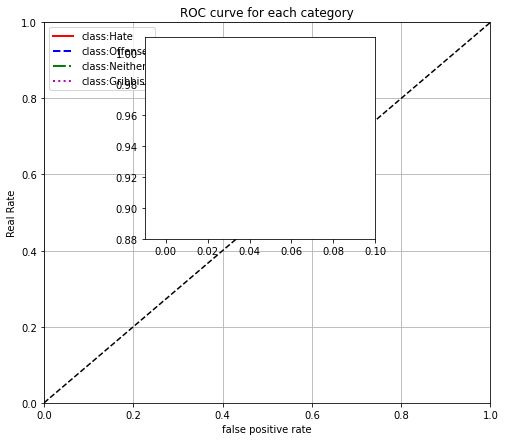

In [33]:
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.metrics import roc_curve
## Visualization of each category ROC curve
lable_names = ["Hate","Offense","Neither", "Gribbish"]
colors = ["r","b","g","m",]
linestyles =["-", "--", "-.", ":", "-"]
pre_score = rf.predict_proba(X_train_vectorized)
fig  = plt.figure(figsize=(8,7))
for ii, color in zip(range(pre_score.shape[1]), colors):
         ## Calculate the value of the ROC curve
    y_test_lb = label_binarize(y_train,classes=[0,1,2,3,])
    fpr_ii, tpr_ii, _ = roc_curve(y_test_lb[:,ii], pre_score[:,ii])
    plt.plot(fpr_ii, tpr_ii,color = color,linewidth = 2,
             linestyle = linestyles[ii],
             label = "class:"+lable_names[ii])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel ("false positive rate")
plt.ylabel ("Real Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.title ("ROC curve for each category")
 ## Add partial enlarged map
inset_ax = fig.add_axes([0.3, 0.45, 0.4, 0.4],facecolor="white")
for ii, color in zip(range(pre_score.shape[1]), colors):
         ## Calculate the value of the ROC curve
    fpr_ii, tpr_ii, _ = roc_curve(y_test_lb[:,ii], pre_score[:,ii])
         ## Local enlargement
    inset_ax.plot(fpr_ii, tpr_ii,color = color,linewidth = 2,
                  linestyle = linestyles[ii])
    inset_ax.set_xlim([-0.01,0.1])
    inset_ax.set_ylim([0.88,1.01])
    inset_ax.grid()
plt.show()

In [34]:
# from sklearn.metrics import roc_curve

# # roc curve for models
# fpr, tpr, thresh = roc_curve(y_test, rf.predict_proba(X_test_vectorized)[:, 3], pos_label=4)
# # roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(y_test))]
# p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
# plt.figure(figsize=(12,10))
# sns.lineplot(x=fpr,y=tpr,);

# plt.xlabel("False Positive Rate");
# plt.ylabel("Sensitivity (TPR)");

In [35]:
# from sklearn.metrics import roc_auc_score
# roc_auc_score(y_test,multi_class='raise', rf.predict_proba(X_test_vectorized)[:, 1])

In [36]:
# def plot_multiclass_roc(rf, X_test, y_test, n_classes, figsize=(17, 6)):
#     y_score = rf.base_estimator_(X_test)

#     # structures
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()

#     # calculate dummies once
#     y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
#     for i in range(n_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # roc for each class
#     fig, ax = plt.subplots(figsize=figsize)
#     ax.plot([0, 1], [0, 1], 'k--')
#     ax.set_xlim([0.0, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     ax.set_title('Receiver operating characteristic example')
#     for i in range(n_classes):
#         ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
#     ax.legend(loc="best")
#     ax.grid(alpha=.4)
#     sns.despine()
#     plt.show()
    
# plot_multiclass_roc(rf_fit, X_test, y_test, n_classes=16, figsize=(16, 10))

In [37]:
# pip install transformers

In [38]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
# aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute",aug_max=3,temperature=0.5)

In [39]:
y_train

7306        Offensive Language
17399    No Hate and Offensive
14093       Offensive Language
22291       Offensive Language
16348       Offensive Language
                 ...          
21575    No Hate and Offensive
5390        Offensive Language
860         Offensive Language
15795       Offensive Language
23654       Offensive Language
Name: class, Length: 19857, dtype: object

In [40]:
X_train[969]

'racist month fuck u'

In [41]:
sum(y_train==0)

0

In [42]:
augmented_sentences=[]
augmented_sentences_labels=[]
for i in X_train.index:
  if y_train[i]==0:
    temps=aug.augment(X_train[i],n=2)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append(0)

In [43]:
data=pd.read_csv("src/neplai_words.csv",encoding= 'unicode_escape')

In [44]:
sorted([len(i) for i in data.loc[data['class']==3]['tweet']])
([i for i in data.loc[data['class']==3]['tweet'] if len(i)==10])

[]

In [45]:
X_train=X_train.append(pd.Series(augmented_sentences),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels),ignore_index=True)

print(X_train.shape)
print(y_train.shape)

(19857,)
(19857,)


In [46]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized=vectorizer.transform(X_test)
rf=RandomForestClassifier(n_estimators=10)

rf.fit(X_train_vectorized,y_train)

RandomForestClassifier(n_estimators=10)

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_train_pred=rf.predict(X_train_vectorized)


print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(accuracy_score(y_train, y_train_pred))

[[   26     0     0     9]
 [    0  1072    12    68]
 [    0     1  3256    40]
 [    0    27    49 15297]]
                        precision    recall  f1-score   support

Gibberish Undetectable       1.00      0.74      0.85        35
           Hate Speech       0.97      0.93      0.95      1152
 No Hate and Offensive       0.98      0.99      0.98      3297
    Offensive Language       0.99      1.00      0.99     15373

              accuracy                           0.99     19857
             macro avg       0.99      0.91      0.95     19857
          weighted avg       0.99      0.99      0.99     19857

0.9896258246462205


In [48]:
y_pred=rf.predict(X_test_vectorized)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[   4    0    0    3]
 [   0   47   28  202]
 [   0    7  721  137]
 [   0   52  132 3632]]
                        precision    recall  f1-score   support

Gibberish Undetectable       1.00      0.57      0.73         7
           Hate Speech       0.44      0.17      0.25       277
 No Hate and Offensive       0.82      0.83      0.83       865
    Offensive Language       0.91      0.95      0.93      3816

              accuracy                           0.89      4965
             macro avg       0.79      0.63      0.68      4965
          weighted avg       0.87      0.89      0.88      4965

0.8870090634441088


In [49]:
# from sklearn.metrics import roc_curve

# # roc curve for models
# fpr, tpr, thresh = roc_curve(y_test, rf.predict_proba(X_test_vectorized)[:, 1], pos_label=1)
# # roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(y_test))]
# p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
# plt.figure(figsize=(12,10))
# sns.lineplot(x=fpr,y=tpr,);

# plt.xlabel("False Positive Rate");
# plt.ylabel("Sensitivity (TPR)");

In [50]:
# roc_auc_score(y_test, rf.predict_proba(X_test_vectorized)[:, 1])

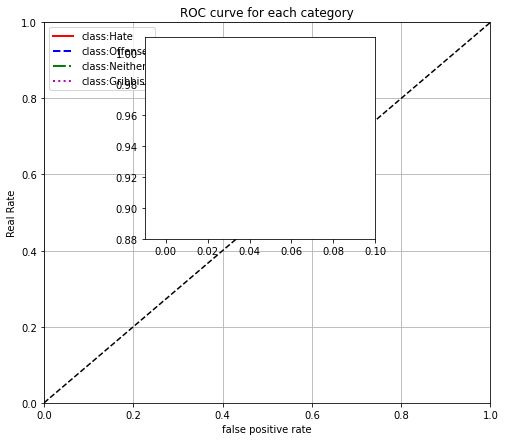

In [51]:
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.metrics import roc_curve
## Visualization of each category ROC curve
lable_names = ["Hate","Offense","Neither", "Gribbish"]
colors = ["r","b","g","m",]
linestyles =["-", "--", "-.", ":", "-"]
pre_score = rf.predict_proba(X_test_vectorized)
fig  = plt.figure(figsize=(8,7))
for ii, color in zip(range(pre_score.shape[1]), colors):
         ## Calculate the value of the ROC curve
    y_test_lb = label_binarize(y_test,classes=[0,1,2,3,])
    fpr_ii, tpr_ii, _ = roc_curve(y_test_lb[:,ii], pre_score[:,ii])
    plt.plot(fpr_ii, tpr_ii,color = color,linewidth = 2,
             linestyle = linestyles[ii],
             label = "class:"+lable_names[ii])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel ("false positive rate")
plt.ylabel ("Real Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.title ("ROC curve for each category")
 ## Add partial enlarged map
inset_ax = fig.add_axes([0.3, 0.45, 0.4, 0.4],facecolor="white")
for ii, color in zip(range(pre_score.shape[1]), colors):
         ## Calculate the value of the ROC curve
    fpr_ii, tpr_ii, _ = roc_curve(y_test_lb[:,ii], pre_score[:,ii])
         ## Local enlargement
    inset_ax.plot(fpr_ii, tpr_ii,color = color,linewidth = 2,
                  linestyle = linestyles[ii])
    inset_ax.set_xlim([-0.01,0.1])
    inset_ax.set_ylim([0.88,1.01])
    inset_ax.grid()
plt.show()

In [52]:
data.shape

(24819, 2)